In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,Normalization
import numpy as np
from sklearn.model_selection import train_test_split,KFold
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tf2onnx
from os import path

In [58]:
with open(path.join("results","results.csv")) as f:
    results = f.readlines()
    
strings = ["h_E", "B", "G", "D", "A", "E"]
labels = np.array([0,1,2,3,4,5])

data = []
label_list = []

for i, line in enumerate(results):
    if i == 0:
        continue
    string,metric,amp_ra,deviation,f0 = line.split(",")
    if string in strings:
        metric = float(metric)
        amp_ra = float(amp_ra)
        deviation = float(deviation)
        f0 = float(f0)
        data.append([metric,amp_ra, deviation,f0])
        label_list.append(labels[strings.index(string)])


data = np.array(data, dtype=np.float32)
label_list = np.array(label_list)




label_count = 6
labels_categorical = tf.keras.utils.to_categorical(label_list, num_classes=label_count)


X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42, shuffle=True)

print(f"Training data shape: {X_train.shape}")  # Should be (num_samples, 2)
print(f"Training labels shape: {y_train.shape}")

Training data shape: (1415, 4)
Training labels shape: (1415, 6)


In [59]:
#normalize data
normalization_layer = Normalization(input_shape=(X_train.shape[1],))
normalization_layer.adapt(X_train)

c:\Program Files\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
model = Sequential([
    normalization_layer,
    Dense(55, activation='relu'),
    BatchNormalization(),  # Helps stabilize training
    Dropout(0.3),
    Dense(55, activation='relu'),
    #Dense(55, activation='relu'),
    #Dense(55, activation='relu'),
    Dense(32, activation='relu'),
   
    Dense(label_count, activation='softmax')
])
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00008), metrics=['accuracy'])

# Train the model

print(model.summary())

#implement early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
# with tf.device('/GPU:0'):
history = model.fit(X_train, y_train, epochs=500, batch_size=30, validation_split=0.2,callbacks=early_stopping)
    

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_7 (Normalization) │ (None, 4)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 55)             │           275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 55)             │           220 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 55)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 55)             │         3,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,574 (21.78 KB)

 Trainable params: 5,455 (21.31 KB)

 Non-trainable params: 119 (480.00 B)

None
Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.1432 - loss: 2.2033 - val_accuracy: 0.1837 - val_loss: 1.8010
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1915 - loss: 2.0843 - val_accuracy: 0.2120 - val_loss: 1.7793
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2188 - loss: 1.8928 - val_accuracy: 0.2226 - val_loss: 1.7508
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2521 - loss: 1.7849 - val_accuracy: 0.2544 - val_loss: 1.7130
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2772 - loss: 1.7082 - val_accuracy: 0.3145 - val_loss: 1.6684
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3330 - loss: 1.6508 - val_accuracy: 0.3958 - val_loss: 1.6182
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3453 - loss: 1.5771 - val_accuracy: 0.4664 - val_loss: 1.5644
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3879 - loss: 1.5292 - val_accuracy: 0.48

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


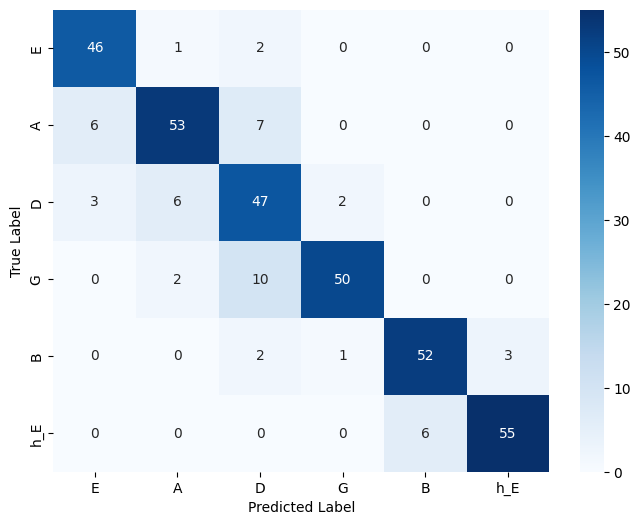

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

stringnames = ["E", "A", "D", "G", "B", "h_E"]
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=stringnames, yticklabels=stringnames)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [62]:
#test model with new data
with open(path.join("results","testresults.csv")) as f:
    new_data = f.readlines()
correct_strings = 0
for line in new_data:
    string,metric,amp_ra,deviation,f0 = line.split(",")
    if string in strings:
        metric = float(metric)
        amp_ra = float(amp_ra)
        deviation = float(deviation)
        f0 = float(f0)
        topredict = [metric,amp_ra, deviation,f0]
        topredict = np.array(topredict, dtype=np.float32)
        topredict = topredict.reshape(1,4)
        prediction = model.predict(topredict)
        # print(f"String: {string}")
        # print(f"Predicted string: {strings[np.argmax(prediction)]}")
        # print(f"Confidence: {np.max(prediction)}")
        if string == strings[np.argmax(prediction)]:
            correct_strings += 1
        print("\n\n")

print(f"Correct strings: {correct_strings}")
#new_data = normalization_layer(new_data)
#print(model.predict(new_data))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



1/1 ━━━━━━━━━━━━

In [63]:
model.save('stringDetectionML.h5')

import os
from os import path
model.output_names=['output']
input_signature = [tf.TensorSpec(model.inputs[0].shape, tf.float32, name='digit')]
print(model.inputs[0].shape) 

(onnx_model_proto, storage) = tf2onnx.convert.from_keras(model,input_signature=input_signature, opset=13)

dir = os.getcwd()
dir = dir.split("/")[0]
while( path.basename(dir) != "TabGenerator"): # go to the TabGenerator directory
    dir = os.path.dirname(dir)

dir = os.path.join(dir, "Assets","MachineLearning","MLModels")
onnxpath_asset_folder = os.path.join(dir, "stringDetectionML_ONNX.onnx")

with open(onnxpath_asset_folder, "wb") as f:
    f.write(onnx_model_proto.SerializeToString())


#export the model to local folder
onnx_path = os.path.join("models", "stringDetectionML_ONNX.onnx")
with open(onnx_path, "wb") as f:
    f.write(onnx_model_proto.SerializeToString())

(None, 4)
